# Quick draw recognition with CNN
In this project I am going to use the Quick draw dataset. Quick draw is one of the Google's A.I. experiments - https://quickdraw.withgoogle.com
I will first train the model. Then convert it to a tensorflow.js model and then I will create a web application with a canvas drawing space that will recognise the drawing using the generated model.

Here is the application: https://didexe.github.io/quickDrawWithMobileNetAndTFJS/

and the Git repo: https://github.com/Didexe/quickDrawWithMobileNetAndTFJS

link to this notebook on Google CoLab:
https://colab.research.google.com/drive/163KILDrDCKGTVhiOU1nwW8MKpQjGfh0i

I first created the web app and tested it using trained models from other people. Then started work on training my models. The idea was to train two different models - one custom CNN and one MobileNet and compare them but as I was using Kaggle and Google Colab the kernels constantly got disconnected and I could not complete the task. 

I initially tried to work with the original dataset containing the strokes from the drawings and using CV2 image generator to convert them to images. This was the better approach as the sequence of the strokes could be color coded in the images(first strokes are black and the following get lighter) which could increase the accuracy of the model. But even with the smallest possible image dimensions 64px x 64px x 1channel it could not complete on an image set of around 1 000 000 samples(3000 samples from each of 340 classes)

Here is the link to the initial notebook on Kaggle:
https://www.kaggle.com/didexe/quick-draw-recognition-with-cnn

Then I downloaded the images in an .npy format in 28px x 28px and using the custom CNN model with the same number of samples I managed to get some results. As running more than 15 epochs in a row was impossible I took another approach. Running 10 epochs and saving the model and the log. Then using the saved model to train for another 10 etc.

# IMPORTS

In [0]:
import os
import urllib.request
import glob
import numpy as np
import pandas as pd
from tensorflow.keras import layers
from tensorflow import keras 
import tensorflow as tf
from tensorflow.keras.metrics import categorical_accuracy, top_k_categorical_accuracy, categorical_crossentropy, Accuracy
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import random
from keras.models import load_model

# LOAD THE DATA

In [0]:
f = open("class_names.txt","r")
classes = f.readlines()
f.close()

In [0]:
classes = [c.replace('\n','').replace(' ','_') for c in classes]

In [4]:
print(classes)

['airplane', 'alarm_clock', 'ambulance', 'angel', 'animal_migration', 'ant', 'anvil', 'apple', 'arm', 'asparagus', 'axe', 'backpack', 'banana', 'bandage', 'barn', 'baseball', 'baseball_bat', 'basket', 'basketball', 'bat', 'bathtub', 'beach', 'bear', 'beard', 'bed', 'bee', 'belt', 'bench', 'bicycle', 'binoculars', 'bird', 'birthday_cake', 'blackberry', 'blueberry', 'book', 'boomerang', 'bottlecap', 'bowtie', 'bracelet', 'brain', 'bread', 'bridge', 'broccoli', 'broom', 'bucket', 'bulldozer', 'bus', 'bush', 'butterfly', 'cactus', 'cake', 'calculator', 'calendar', 'camel', 'camera', 'camouflage', 'campfire', 'candle', 'cannon', 'canoe', 'car', 'carrot', 'castle', 'cat', 'ceiling_fan', 'cell_phone', 'cello', 'chair', 'chandelier', 'church', 'circle', 'clarinet', 'clock', 'cloud', 'coffee_cup', 'compass', 'computer', 'cookie', 'cooler', 'couch', 'cow', 'crab', 'crayon', 'crocodile', 'crown', 'cruise_ship', 'cup', 'diamond', 'dishwasher', 'diving_board', 'dog', 'dolphin', 'donut', 'door', 'dr

In [0]:
!mkdir data

In [0]:
def download():
  
  base = 'https://storage.googleapis.com/quickdraw_dataset/full/numpy_bitmap/'
  for c in classes:
    cls_url = c.replace('_', '%20')
    path = base+cls_url+'.npy'
    print(path)
    urllib.request.urlretrieve(path, 'data/'+c+'.npy')

In [0]:
download()

# VARIABLES AND FUNCTIONS

In [0]:
IMAGE_SIZE = 28
ALL_FILES = all_files = glob.glob(os.path.join(root, '*.npy'))

In [0]:
def load_data(root, vfold_ratio=0.2, max_items_per_class= 3000 ):

    #initialize variables 
    x = np.empty([0, 784])
    y = np.empty([0])
    class_names = []

    #load each data file 
    for idx, file in enumerate(all_files):
        data = np.load(file)
        data = data[0: max_items_per_class, :]
        labels = np.full(data.shape[0], idx)

        x = np.concatenate((x, data), axis=0)
        y = np.append(y, labels)

        class_name, ext = os.path.splitext(os.path.basename(file))
        class_names.append(class_name)
    
    #randomize the dataset 
    permutation = np.random.permutation(y.shape[0])
    x = x[permutation, :]
    y = y[permutation]

    #separate into training and testing 
    vfold_size = int(x.shape[0]/100*(vfold_ratio*100))

    x_test = x[0:vfold_size, :]
    y_test = y[0:vfold_size]

    x_train = x[vfold_size:x.shape[0], :]
    y_train = y[vfold_size:y.shape[0]]
    return x_train, y_train, x_test, y_test, class_names

In [0]:
def top_3_accuracy(y_true, y_pred):
    return keras.metrics.top_k_categorical_accuracy(y_true, y_pred, k=3)

In [0]:
def plot_images(x):
    n = 8
    fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(12, 12))
    for i in range(n**2):
        ax = axs[i // n, i % n]
        (-x[i]+1)/2
        ax.imshow(x[i].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap=plt.cm.gray)
        ax.axis('off')
    plt.tight_layout()
    fig.savefig('gs.png', dpi=300)
    plt.show();

# PREPARE TRAINING AND TESTING DATAFRAMES

In [0]:
x_train, y_train, x_test, y_test, class_names = load_data('data')
num_classes = len(class_names)
# 340

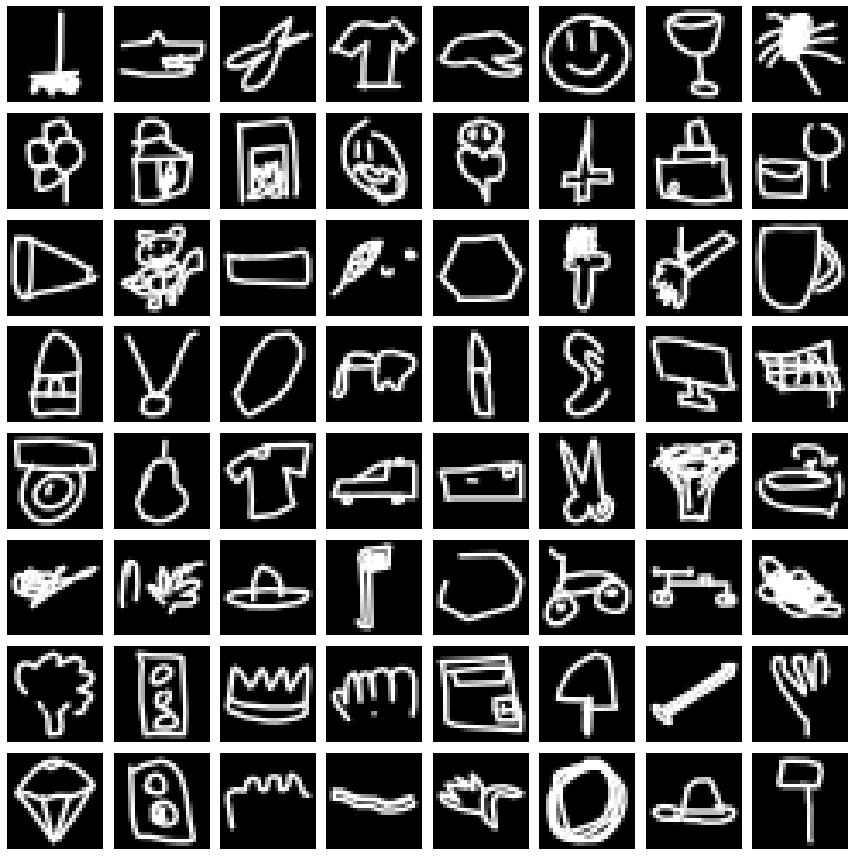

In [16]:
# print some random images from the training set
plot_images(x_train)

In [0]:
# reshape
x_train = x_train.reshape(x_train.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1).astype('float32')
x_test = x_test.reshape(x_test.shape[0], IMAGE_SIZE, IMAGE_SIZE, 1).astype('float32')

# normalize
x_train /= 255.0
x_test /= 255.0

# Convert class vectors to class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [18]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(816000, 28, 28, 1)
(816000, 340)
(204000, 28, 28, 1)
(204000, 340)


# THE MODEL

A custom CNN with 9 layers. 3 convolutional and 3 maxpooling.

In [19]:
model = keras.Sequential()
model.add(layers.Convolution2D(16, (3, 3),
                        padding='same',
                        input_shape=x_train.shape[1:], activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(32, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Convolution2D(64, (3, 3), padding='same', activation= 'relu'))
model.add(layers.MaxPooling2D(pool_size =(2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(340, activation='softmax')) 
# Train model

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.002),
             metrics=['accuracy', categorical_accuracy, categorical_crossentropy, top_3_accuracy])
print(model.summary())

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)          0         
_________________________________________

# MODEL TRAINING

I experimented with different parameters during the 10 epoch runs to try to find a way for quicker conversion but I actually got the oposite. In the beginning it was going well but after the 50th epoch the loss and accuracy started going in the opposite directions wich I think was due to the removing of the ReduceLROnPlateau callback.

In [0]:
callbacks = [
    ReduceLROnPlateau(monitor='val_top_3_accuracy', factor=0.75, patience=3, min_delta=0.001,
                          mode='max', min_lr=1e-5, verbose=1),
    ModelCheckpoint('model.h5', monitor='val_top_3_accuracy', mode='max', save_best_only=True),
]

history = model.fit(
    x_train, y_train, epochs=50, verbose=1,
    validation_split=0.1,
    # validation_data=(x_test, y_test),
    callbacks = callbacks
)


Train on 734400 samples, validate on 81600 samples
Epoch 1/50
734400/734400 [==============================] - 312s 424us/sample - loss: 2.6296 - acc: 0.4061 - categorical_accuracy: 0.4061 - categorical_crossentropy: 2.6296 - top_3_accuracy: 0.6055 - val_loss: 2.2812 - val_acc: 0.4700 - val_categorical_accuracy: 0.4700 - val_categorical_crossentropy: 2.2812 - val_top_3_accuracy: 0.6758
Epoch 2/50
734400/734400 [==============================] - 284s 387us/sample - loss: 2.1942 - acc: 0.4892 - categorical_accuracy: 0.4892 - categorical_crossentropy: 2.1941 - top_3_accuracy: 0.6924 - val_loss: 2.1398 - val_acc: 0.5014 - val_categorical_accuracy: 0.5014 - val_categorical_crossentropy: 2.1398 - val_top_3_accuracy: 0.7041
Epoch 3/50
734400/734400 [==============================] - 308s 420us/sample - loss: 2.1248 - acc: 0.5038 - categorical_accuracy: 0.5038 - categorical_crossentropy: 2.1248 - top_3_accuracy: 0.7057 - val_loss: 2.1168 - val_acc: 0.5095 - val_categorical_accuracy: 0.5095 - v

In [0]:
log = pd.DataFrame.from_dict(history.history)
log.to_csv('train_log.csv', index=False)

In [0]:
model.save('model.hdf5')

In [80]:
model_1 = tf.keras.models.load_model('model.hdf5', custom_objects = {'top_3_accuracy':top_3_accuracy})

model_1.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.002),
             metrics=['accuracy', categorical_accuracy, categorical_crossentropy, top_3_accuracy])
print(model_1.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 576)              

In [81]:
history_1 = model_1.fit(
    x_train, y_train, epochs=10, verbose=1,
    validation_data=(x_test, y_test),
    callbacks = callbacks
)

Train on 816000 samples, validate on 816000 samples
Epoch 1/10
816000/816000 [==============================] - 374s 458us/sample - loss: 1.9681 - acc: 0.5352 - categorical_accuracy: 0.5352 - categorical_crossentropy: 1.9681 - top_3_accuracy: 0.7334 - val_loss: 1.9708 - val_acc: 0.5333 - val_categorical_accuracy: 0.5333 - val_categorical_crossentropy: 1.9708 - val_top_3_accuracy: 0.7317
Epoch 2/10
816000/816000 [==============================] - 364s 447us/sample - loss: 1.9702 - acc: 0.5350 - categorical_accuracy: 0.5350 - categorical_crossentropy: 1.9702 - top_3_accuracy: 0.7330 - val_loss: 1.9570 - val_acc: 0.5381 - val_categorical_accuracy: 0.5381 - val_categorical_crossentropy: 1.9569 - val_top_3_accuracy: 0.7355
Epoch 3/10
816000/816000 [==============================] - 363s 445us/sample - loss: 1.9726 - acc: 0.5346 - categorical_accuracy: 0.5346 - categorical_crossentropy: 1.9726 - top_3_accuracy: 0.7326 - val_loss: 1.9767 - val_acc: 0.5349 - val_categorical_accuracy: 0.5349 - 

In [0]:
model_1.save('model.hdf5')

In [0]:
history_8 = model_2.fit(
    x_train, y_train, epochs=10, verbose=1,
    # validation_data=(x_test, y_test),
    batch_size = 100,
    validation_split=0.1,
#     callbacks = [
#     ModelCheckpoint('model.h5', monitor='val_top_3_accuracy', mode='max', save_best_only=True)
# ]
    callbacks=callbacks
)
model_2.save('model.hdf5')
log = pd.DataFrame.from_dict(history_8.history)
log.to_csv('train_log_8.csv', index=False)


Train on 734400 samples, validate on 81600 samples
Epoch 1/10
734400/734400 [==============================] - 220s 300us/sample - loss: 1.7803 - acc: 0.5761 - categorical_accuracy: 0.5761 - categorical_crossentropy: 1.7803 - top_3_accuracy: 0.7679 - val_loss: 1.8723 - val_acc: 0.5577 - val_categorical_accuracy: 0.5577 - val_categorical_crossentropy: 1.8723 - val_top_3_accuracy: 0.7522
Epoch 2/10
734400/734400 [==============================] - 209s 285us/sample - loss: 1.7835 - acc: 0.5755 - categorical_accuracy: 0.5755 - categorical_crossentropy: 1.7835 - top_3_accuracy: 0.7672 - val_loss: 1.8780 - val_acc: 0.5585 - val_categorical_accuracy: 0.5585 - val_categorical_crossentropy: 1.8780 - val_top_3_accuracy: 0.7498
Epoch 3/10
734400/734400 [==============================] - 188s 256us/sample - loss: 1.7842 - acc: 0.5748 - categorical_accuracy: 0.5748 - categorical_crossentropy: 1.7842 - top_3_accuracy: 0.7666 - val_loss: 1.8332 - val_acc: 0.5700 - val_categorical_accuracy: 0.5700 - v

# METRICS

I combined the logs from all runs to see the learning trend of my model.

In [0]:
log = pd.DataFrame.from_dict(history_1.history)
log.to_csv('train_log_1.csv', index=False)

In [0]:
log_df_1 = pd.read_csv('train_log.csv')
log_df_2 = pd.read_csv('train_log_1.csv')
log_df_3 = pd.read_csv('train_log_2.csv')
log_df_4 = pd.read_csv('train_log_3.csv')
log_df_5 = pd.read_csv('train_log_4.csv')
log_df_6 = pd.read_csv('train_log_5.csv')
log_df_7 = pd.read_csv('train_log_6.csv')
log_df_8 = pd.read_csv('train_log_7.csv')

frames = [log_df_1, log_df_2, log_df_3, log_df_4, log_df_5, log_df_6, log_df_7, log_df_8]
log_df = pd.concat(frames, sort=False, ignore_index=True)

In [10]:
log_df

,loss,acc,categorical_accuracy,categorical_crossentropy,top_3_accuracy,val_loss,val_acc,val_categorical_accuracy,val_categorical_crossentropy,val_top_3_accuracy,lr
0,2.514044,0.430043,0.430043,2.514047,0.629048,2.187445,0.487913,0.487913,2.187447,0.692051,0.0020
1,2.113503,0.506137,0.506137,2.113498,0.707613,2.037287,0.520614,0.520614,2.037297,0.720061,0.0020
2,2.052235,0.518362,0.518362,2.052233,0.718534,1.983271,0.531854,0.531854,1.983264,0.731078,0.0020
3,2.022978,0.524697,0.524697,2.022974,0.723907,2.005809,0.525933,0.525933,2.005810,0.726415,0.0020
4,2.008461,0.527447,0.527447,2.008465,0.726463,1.965443,0.536687,0.536687,1.965438,0.733146,0.0020
...,...,...,...,...,...,...,...,...,...,...,...
75,1.746630,0.583419,0.583419,1.746630,0.773980,1.799708,0.576078,0.576078,1.799707,0.765257,0.0015
76,1.741943,0.584382,0.584382,1.741944,0.773901,1.816252,0.573713,0.573713,1.816252,0.762904,0.0015
77,1.740446,0.584515,0.584515,1.740448,0.774481,1.793589,0.577181,0.577181,1.793588,0.766667,0.0015
78,1.739059,0.585357,0.585357,1.739058,0.775008,1.812403,0.572243,0.572243,1.812404,0.763088,0.0015


Text(0.5, 0, 'Epochs')

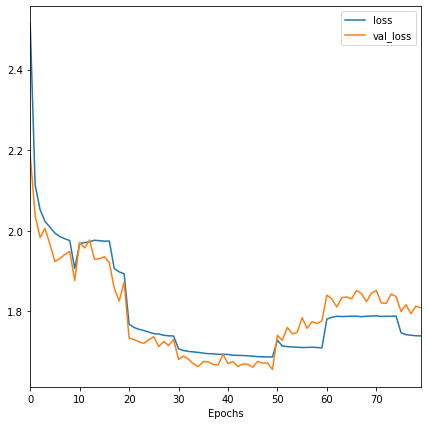

In [11]:
p = log_df[['loss','val_loss']].plot(figsize = (7,7))
p.set_xlabel('Epochs')

Text(0.5, 0, 'Epochs')

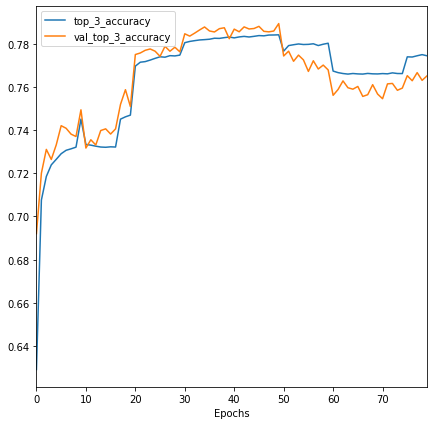

In [12]:
p = log_df[['top_3_accuracy','val_top_3_accuracy']].plot(figsize = (7,7))
p.set_xlabel('Epochs')

In [0]:
score = model.evaluate(x_test, y_test, verbose=0)

# RESOURCES

1. https://github.com/googlecreativelab/quickdraw-dataset#preprocessed-dataset
2. https://www.kaggle.com/c/quickdraw-doodle-recognition
3. https://www.kaggle.com/echomil/mobilenet-126x126x3-100k-per-class
4. https://www.kaggle.com/gaborfodor/greyscale-mobilenet-lb-0-892
5. https://colab.research.google.com/github/zaidalyafeai/zaidalyafeai.github.io/blob/master/sketcher/Sketcher.ipynb#scrollTo=7OMEJ7kF3lsP